<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indicators/blob/main/Code/XGBoost_Regressor_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings("ignore")

# **XGBOOST REGRESSOR**

**First, we plot the ACF for every feature to determine the amount of lags needed and the interval between them, since the granularity is 1 sec.**

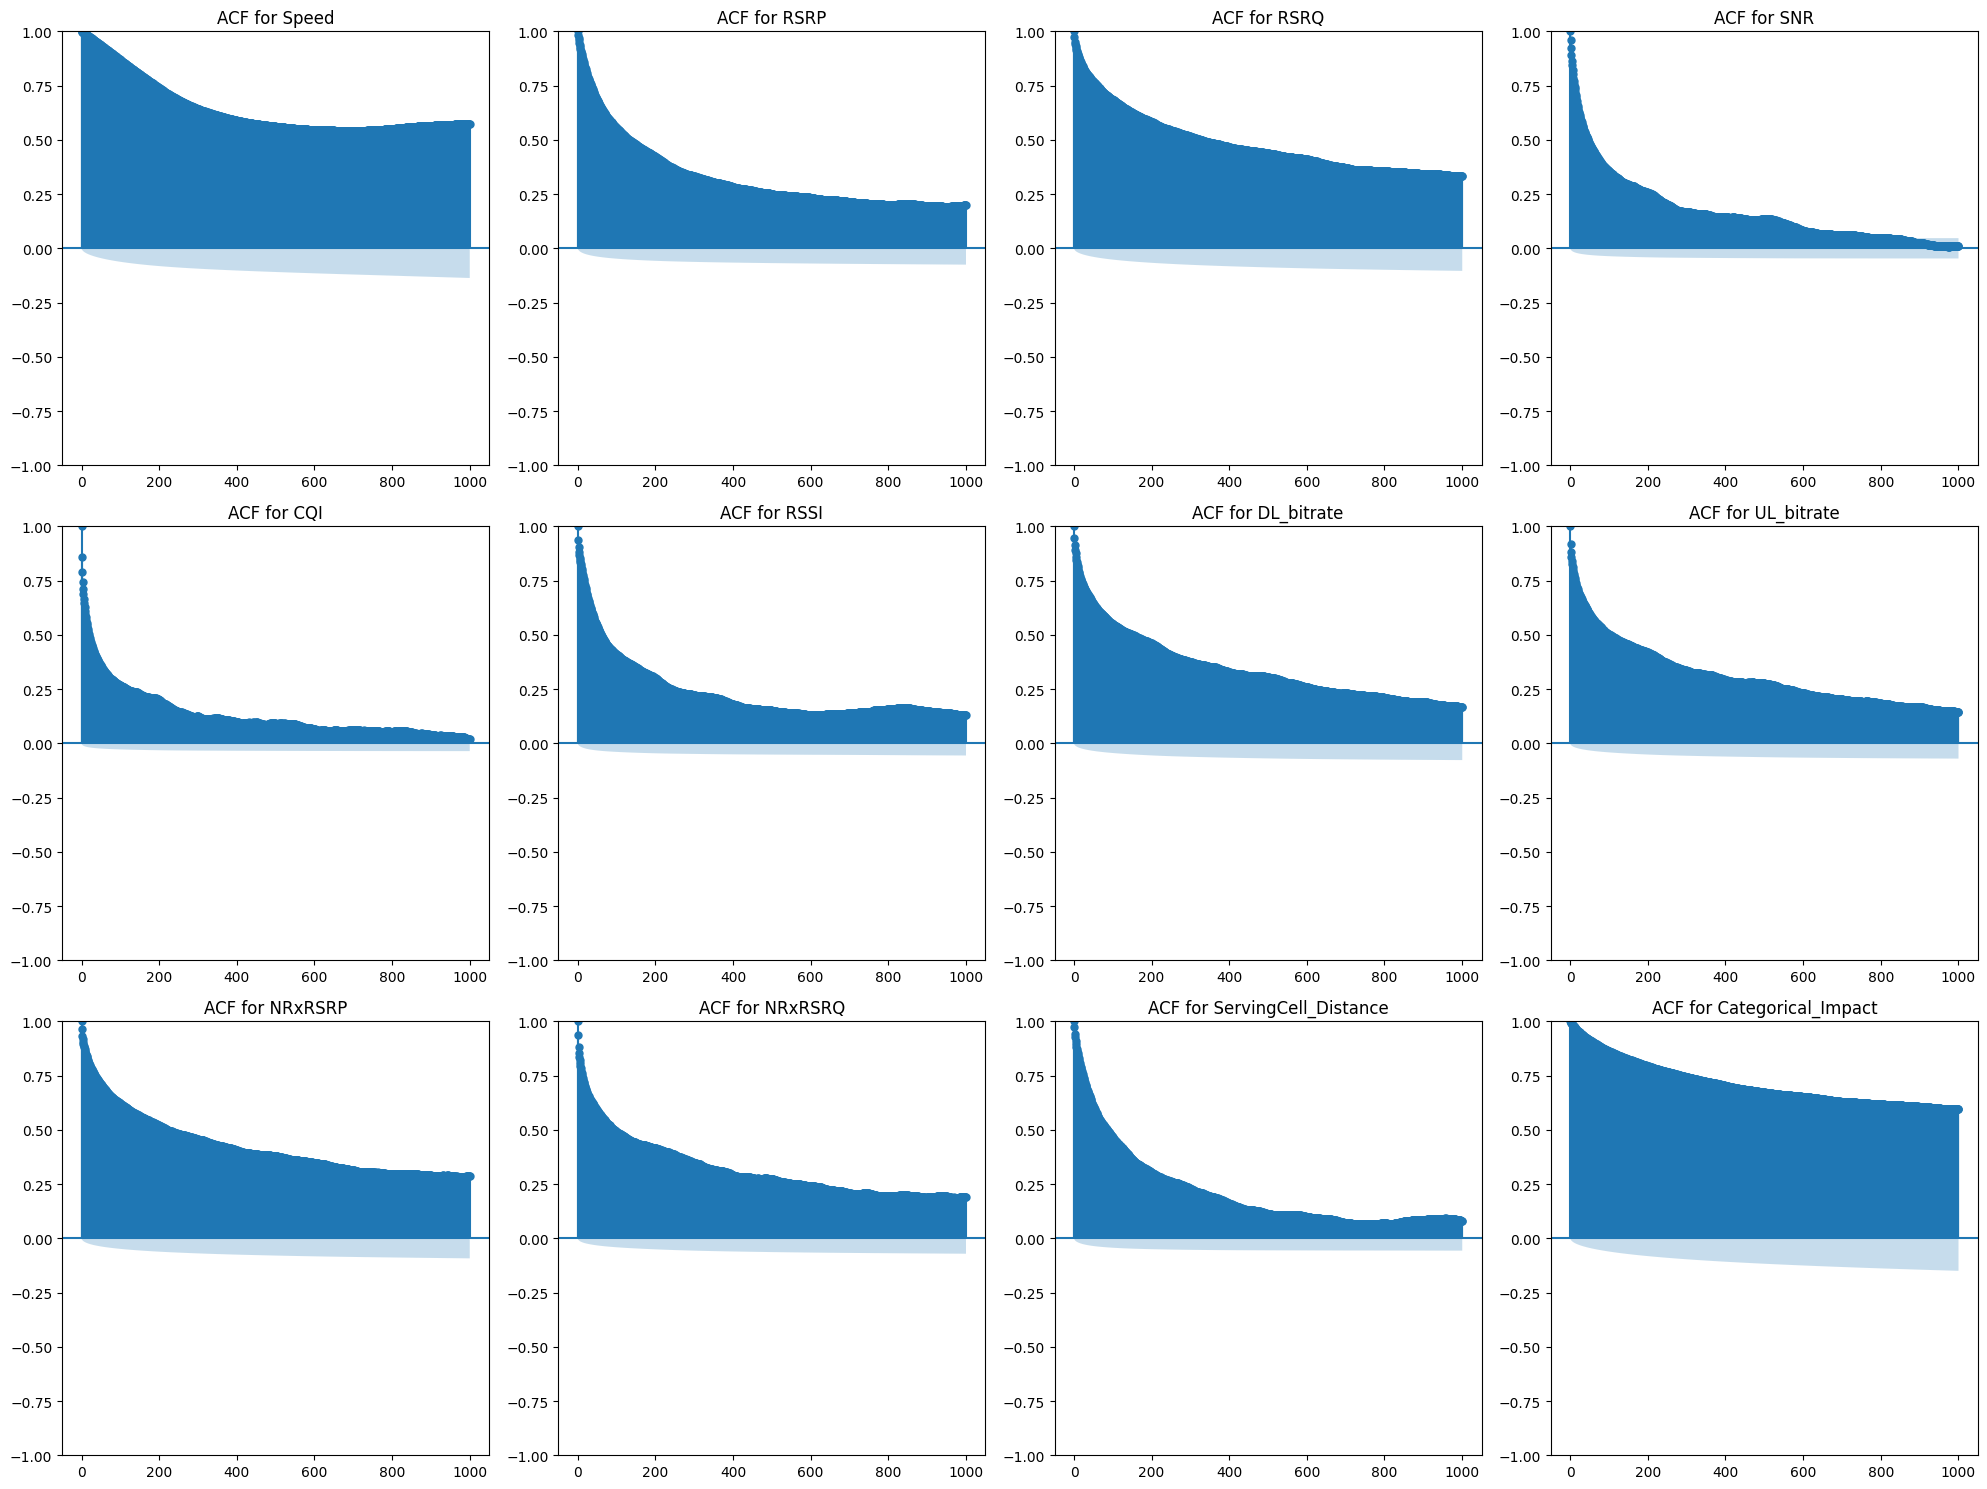

In [5]:
# Φόρτωση του τελικού dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")

# Επιλογή όλων των αριθμητικών στηλών (όπως ορίζονται)
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# Υπολογισμός και σχεδίαση ACF για κάθε αριθμητικό χαρακτηριστικό
rows, cols = 3, 4
num_features = len(features)
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, column in enumerate(features):
    row, col = divmod(i, cols)  # Υπολογισμός θέσης στο grid
    sm.graphics.tsa.plot_acf(df[column].dropna(), lags=1000, alpha=0.05, ax=axes[row, col])
    axes[row, col].set_title(f"ACF for {column}")

plt.tight_layout()
plt.show()

**Then, we apply Grid Search with 5-Cross Validation to determine the best combination of the hyperparameters for the different amount of lagged features. We split the Dataset into the following subsets:**

**Training Set: 70%**

**Validation Set: 15%**

**Test Set: 15%**

**We also apply Z-Score Normalization since the numeric features are measured in different units.**

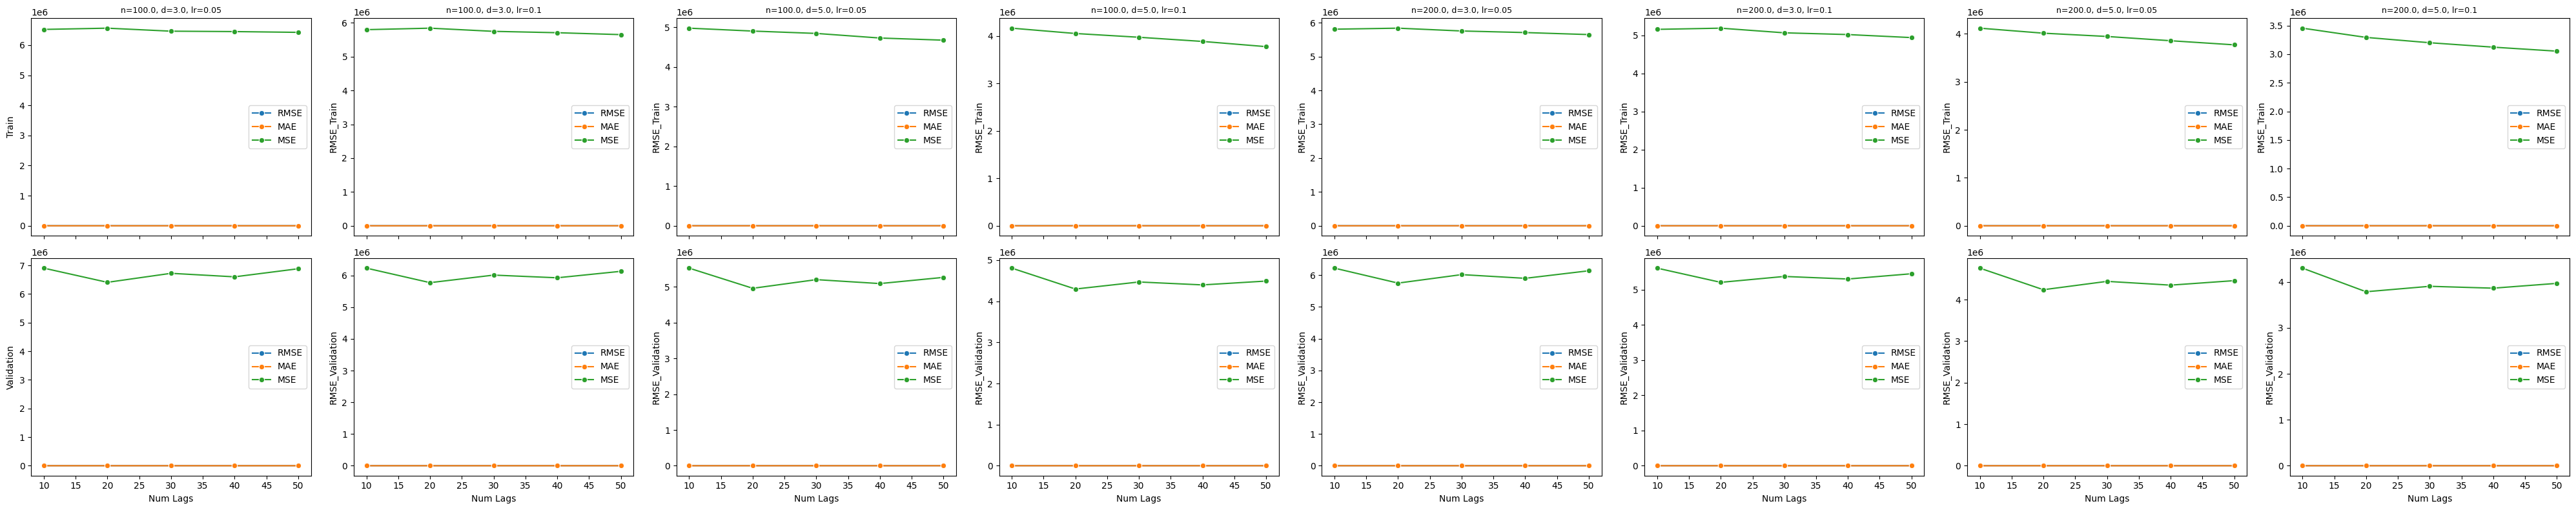

In [ ]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Πίνακας για αποθήκευση αποτελεσμάτων
results_list = []

# --- Παράμετροι
lag_interval = 60  # Λαμβάνουμε δείγμα κάθε 1 λεπτό
num_lags_list = [10, 20, 30, 40, 50] # Πάμε πίσω στο χρόνο από 10 ως 50 λεπτά
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1]
}

# --- Συνδυασμοί υπερπαραμέτρων
param_combinations = list(product(param_grid["n_estimators"],
                                  param_grid["max_depth"],
                                  param_grid["learning_rate"]))

# --- Δημιουργία scalers για κανονικοποίηση
scaler_X = StandardScaler()  # Για τα χαρακτηριστικά
scaler_y = StandardScaler()  # Για τον στόχο

# --- Κύριος βρόχος: num_lags + hyperparameters
for num_lags in num_lags_list:
    df_lagged = create_lagged_features(df, features, num_lags, lag_interval=lag_interval)

    # Διαχωρισμός χαρακτηριστικών και στόχου
    X = df_lagged.drop(columns=["DL_bitrate"])
    y = df_lagged["DL_bitrate"]

    # Κανονικοποίηση των χαρακτηριστικών
    X_scaled = scaler_X.fit_transform(X)

    # Κανονικοποίηση του στόχου (y)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Διαχωρισμός δεδομένων
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    for n_estimators, max_depth, learning_rate in param_combinations:
        # Εκπαίδευση μοντέλου
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            objective="reg:squarederror",
            random_state=42
        )
        model.fit(X_train, y_train)

        # Προβλέψεις
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Αποκανονικοποίηση των προβλέψεων (inverse transform)
        y_train_pred_denorm = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
        y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()

        # Καταγραφή αποτελεσμάτων
        results_list.append({
            "num_lags": num_lags,
            "lag_interval": lag_interval,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "MSE_Train": mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm),
            "RMSE_Train": np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm)),
            "MAE_Train": mean_absolute_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm),
            "MSE_Validation": mean_squared_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm),
            "RMSE_Validation": np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm)),
            "MAE_Validation": mean_absolute_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm)
        })

# --- Δημιουργία DataFrame με τα αποτελέσματα
results_df = pd.DataFrame(results_list)

# --- Εμφάνιση γραφικών (Train και Validation)
metrics = ["RMSE", "MAE", "MSE"]
metric_suffixes = ["Train", "Validation"]

# Συνδυασμοί υπερπαραμέτρων
hyperparam_combinations = results_df[["n_estimators", "max_depth", "learning_rate"]].drop_duplicates()
n_rows = 2
n_cols = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)

# Εξασφάλιση σωστών διαστάσεων στο grid
axes = axes.reshape(n_rows, n_cols)

for col_idx, (_, combo) in enumerate(hyperparam_combinations.iterrows()):
    mask = (
        (results_df["n_estimators"] == combo["n_estimators"]) &
        (results_df["max_depth"] == combo["max_depth"]) &
        (results_df["learning_rate"] == combo["learning_rate"])
    )
    combo_data = results_df[mask].sort_values("num_lags")

    for row_idx in range(2):  # 0: Train, 1: Validation
        ax = axes[row_idx, col_idx]

        for metric in metrics:
            sns.lineplot(
                data=combo_data,
                x="num_lags",
                y=f"{metric}_{metric_suffixes[row_idx]}",
                marker="o",
                ax=ax,
                label=f"{metric}"
            )

        # Τίτλος σε κάθε στήλη
        if row_idx == 0:
            ax.set_title(f"n={combo['n_estimators']}, d={combo['max_depth']}, lr={combo['learning_rate']}", fontsize=9)

        # Ονομασίες αξόνων
        ax.set_xlabel("Num Lags")
        if col_idx == 0:
            ax.set_ylabel(f"{metric_suffixes[row_idx]}")

plt.tight_layout()
plt.show()

**We train the model using the best combination of lags and hyperparameters and use the test set for the evaluation of the predictions. We also plot the learning curves of the model.**

In [ ]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Δημιουργία lagged χαρακτηριστικών με τα καλύτερα lags
best_num_lags = 10  # Όπως βρήκαμε από τα αποτελέσματα

df_lagged = create_lagged_features(df, features, best_num_lags, lag_interval=60)

# Διαχωρισμός χαρακτηριστικών και στόχου
X = df_lagged.drop(columns=["Timestamp", "DL_bitrate"])
y = df_lagged["DL_bitrate"]

# --- Δημιουργία scalers για κανονικοποίηση
scaler_X = StandardScaler()  # Για τα χαρακτηριστικά
scaler_y = StandardScaler()  # Για τον στόχο

# Κανονικοποίηση των χαρακτηριστικών
X_scaled = scaler_X.fit_transform(X)

# Κανονικοποίηση του στόχου (y)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Διαχωρισμός δεδομένων
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Δημιουργία του τελικού μοντέλου με τις καλύτερες υπερπαραμέτρους
final_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42
)

# Εκπαίδευση του μοντέλου με όλα τα δεδομένα εκπαίδευσης
final_model.fit(X_train, y_train)

# Προβλέψεις στο test set
y_test_pred = final_model.predict(X_test)

# Αποκανονικοποίηση των προβλέψεων
y_test_pred_denorm = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Δημιουργία μιας νέας στήλης με τις προβλεπόμενες τιμές στο αρχικό df
df.loc[len(df) - len(y_test_pred_denorm):, 'Predicted_DL_bitrate'] = y_test_pred_denorm

# Υπολογισμός μετρικών απόδοσης στο test set
test_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm))
test_mae = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm)
test_mse = mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")

Test RMSE: 2046.4749203132537
Test MAE: 1130.2818172652921
Test MSE: 4188059.599471138


[0]	train-rmse:0.90784	train-mae:0.73044	eval-rmse:0.91119	eval-mae:0.73305	test-rmse:0.90240	test-mae:0.72537
[10]	train-rmse:0.39233	train-mae:0.29450	eval-rmse:0.39715	eval-mae:0.29687	test-rmse:0.39072	test-mae:0.29200
[20]	train-rmse:0.25483	train-mae:0.16224	eval-rmse:0.26181	eval-mae:0.16532	test-rmse:0.25617	test-mae:0.16188
[30]	train-rmse:0.22382	train-mae:0.12483	eval-rmse:0.23279	eval-mae:0.12847	test-rmse:0.22743	test-mae:0.12586
[40]	train-rmse:0.21253	train-mae:0.11448	eval-rmse:0.22231	eval-mae:0.11866	test-rmse:0.21732	test-mae:0.11630
[50]	train-rmse:0.20596	train-mae:0.11084	eval-rmse:0.21691	eval-mae:0.11570	test-rmse:0.21157	test-mae:0.11309
[60]	train-rmse:0.20163	train-mae:0.10900	eval-rmse:0.21343	eval-mae:0.11420	test-rmse:0.20817	test-mae:0.11165
[70]	train-rmse:0.19752	train-mae:0.10728	eval-rmse:0.20974	eval-mae:0.11266	test-rmse:0.20482	test-mae:0.11021
[80]	train-rmse:0.19445	train-mae:0.10607	eval-rmse:0.20737	eval-mae:0.11171	test-rmse:0.20237	test-mae:0

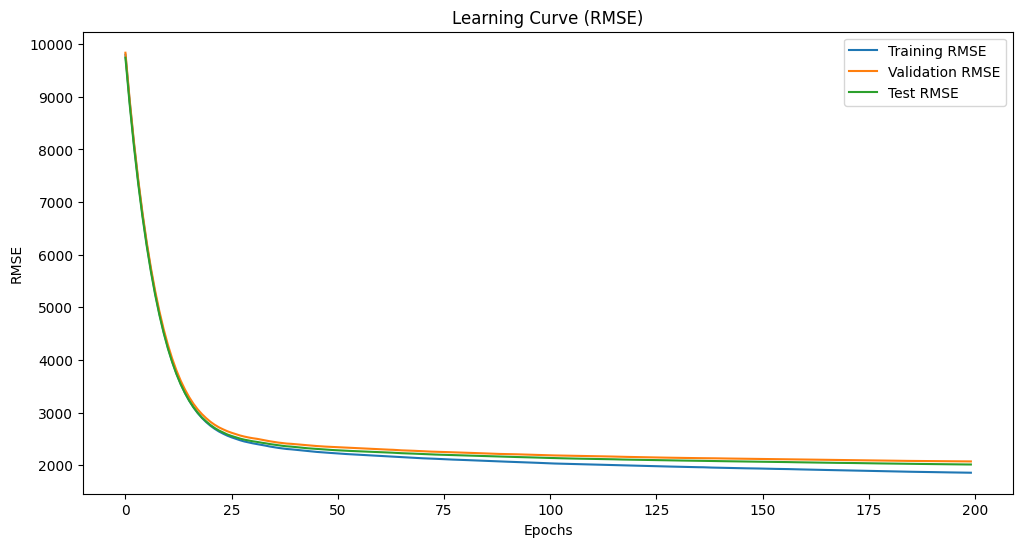

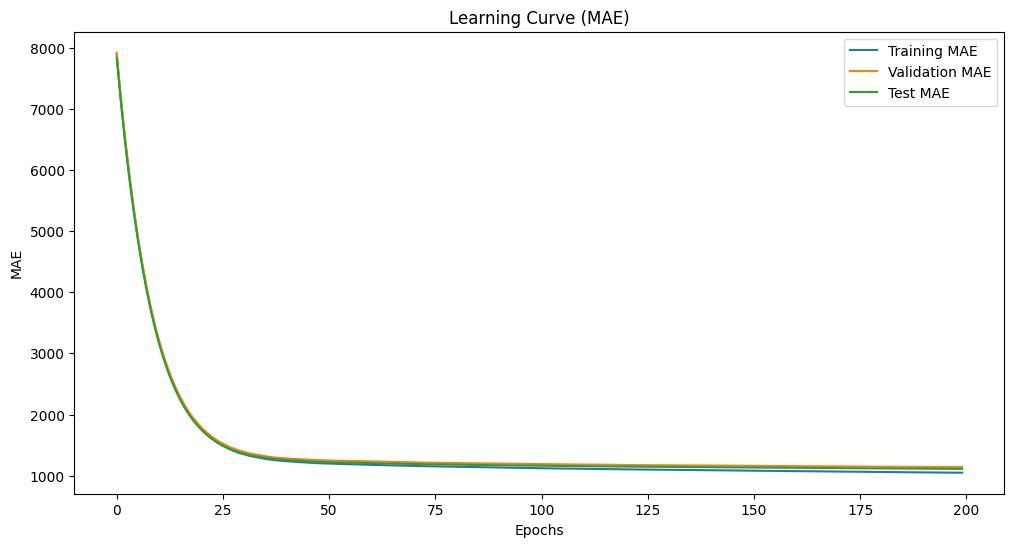

Train RMSE: 1858.6136870334915
Train MAE: 1048.2660223206994
--------------------------------------------
Validation RMSE: 2073.1203426678367
Validation MAE: 1140.5184192465003
--------------------------------------------
Test RMSE: 2015.0178600763575
Test MAE: 1111.1359763287874


In [6]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Δημιουργία lagged χαρακτηριστικών με τα καλύτερα lags
best_num_lags = 10  # Όπως βρήκαμε από τα αποτελέσματα

df_lagged = create_lagged_features(df, features, best_num_lags, lag_interval=60)

# Διαχωρισμός χαρακτηριστικών και στόχου
X = df_lagged.drop(columns=[ "DL_bitrate"])
y = df_lagged["DL_bitrate"]

# --- Δημιουργία scalers για κανονικοποίηση
scaler_X = StandardScaler()  # Για τα χαρακτηριστικά
scaler_y = StandardScaler()  # Για τον στόχο

# Κανονικοποίηση των χαρακτηριστικών
X_scaled = scaler_X.fit_transform(X)

# Κανονικοποίηση του στόχου (y)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Διαχωρισμός δεδομένων σε train, validation και test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Δημιουργία DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Ορισμός βέλτιστων υπερπαραμέτρων
params = {
    'objective': 'reg:squarederror',  # Προβλεπτικό σφάλμα
    'max_depth': 5,                   # Βάθος του δέντρου
    'learning_rate': 0.1,             # Ρυθμός εκμάθησης
    'n_estimators': 200,              # Αριθμός δέντρων
    'eval_metric': ['rmse', 'mae']    # Προσθήκη MAE ως μετρικής
}

# Ορισμός evals (train, validation, test set)
evals = [(dtrain, 'train'), (dval, 'eval'), (dtest, 'test')]

# Εκπαίδευση του μοντέλου
num_round = 200  # Αριθμός εποχών (iterations)
history = dict()

bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=10, evals_result=history)

# Λήψη αποτελεσμάτων εκπαίδευσης για τις μετρικές
results = history

# --- Αποκανονικοποίηση των μετρικών για τα learning curves
epochs = len(results['train']['rmse'])  # Αριθμός εποχών

# Ανάκτηση των πραγματικών τιμών από τις κανονικοποιημένες τιμές
train_rmse = np.array(results['train']['rmse']) * np.std(y)  # Αποκανονικοποίηση
eval_rmse = np.array(results['eval']['rmse']) * np.std(y)
test_rmse = np.array(results['test']['rmse']) * np.std(y)

train_mae = np.array(results['train']['mae']) * np.std(y)  # Αποκανονικοποίηση
eval_mae = np.array(results['eval']['mae']) * np.std(y)
test_mae = np.array(results['test']['mae']) * np.std(y)

# --- Σχεδίαση Learning Curves για RMSE
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_rmse, label="Training RMSE")
plt.plot(range(epochs), eval_rmse, label="Validation RMSE")
plt.plot(range(epochs), test_rmse, label="Test RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE)")
plt.legend()
plt.show()

# --- Σχεδίαση Learning Curves για MAE
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_mae, label="Training MAE")
plt.plot(range(epochs), eval_mae, label="Validation MAE")
plt.plot(range(epochs), test_mae, label="Test MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Learning Curve (MAE)")
plt.legend()
plt.show()

# Προβλέψεις στο test set
y_test_pred = bst.predict(dtest)

# Αποκανονικοποίηση των προβλέψεων για το test set
y_test_pred_denorm = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Δημιουργία μιας νέας στήλης με τις προβλεπόμενες τιμές στο αρχικό df
df.loc[len(df) - len(y_test_pred_denorm):, 'Predicted_DL_bitrate'] = y_test_pred_denorm

# Υπολογισμός μετρικών απόδοσης στο training set
y_train_pred = bst.predict(dtrain)
y_train_pred_denorm = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()

train_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm))
train_mae = mean_absolute_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_train_pred_denorm)

print(f"Train RMSE: {train_rmse}")
print(f"Train MAE: {train_mae}")
print("--------------------------------------------")

# Υπολογισμός μετρικών απόδοσης στο validation set
y_val_pred = bst.predict(dval)
y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()

val_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm))
val_mae = mean_absolute_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_val_pred_denorm)

print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print("--------------------------------------------")

# Υπολογισμός μετρικών απόδοσης στο test set
test_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm))
test_mae = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_test_pred_denorm)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

**We calculate for better understanding the percentages of the error metrics to see how far the predictions are from the average actual DL_bitrate of the test data.**

In [7]:
# Υπολογισμός της μέσης πραγματικής τιμής του test set
mean_actual_value = y.mean()

# Αξιολόγηση των μετρικών σφάλματος ως προς τη μέση πραγματική τιμή
print(f"Average Actual DL bitrate of tested samples: {mean_actual_value:.2f} Kbps")
print(f"Percentage of MAE: {(test_mae / mean_actual_value) * 100:.2f}%")
print(f"Percentage of RMSE: {(test_rmse / mean_actual_value) * 100:.2f}%")

Average Actual DL bitrate of tested samples: 9805.00 Kbps
Percentage of MAE: 11.33%
Percentage of RMSE: 20.55%


**Finally, after the evaluation of the model we plot the actual and the predicted timeseries to visualize the results.**

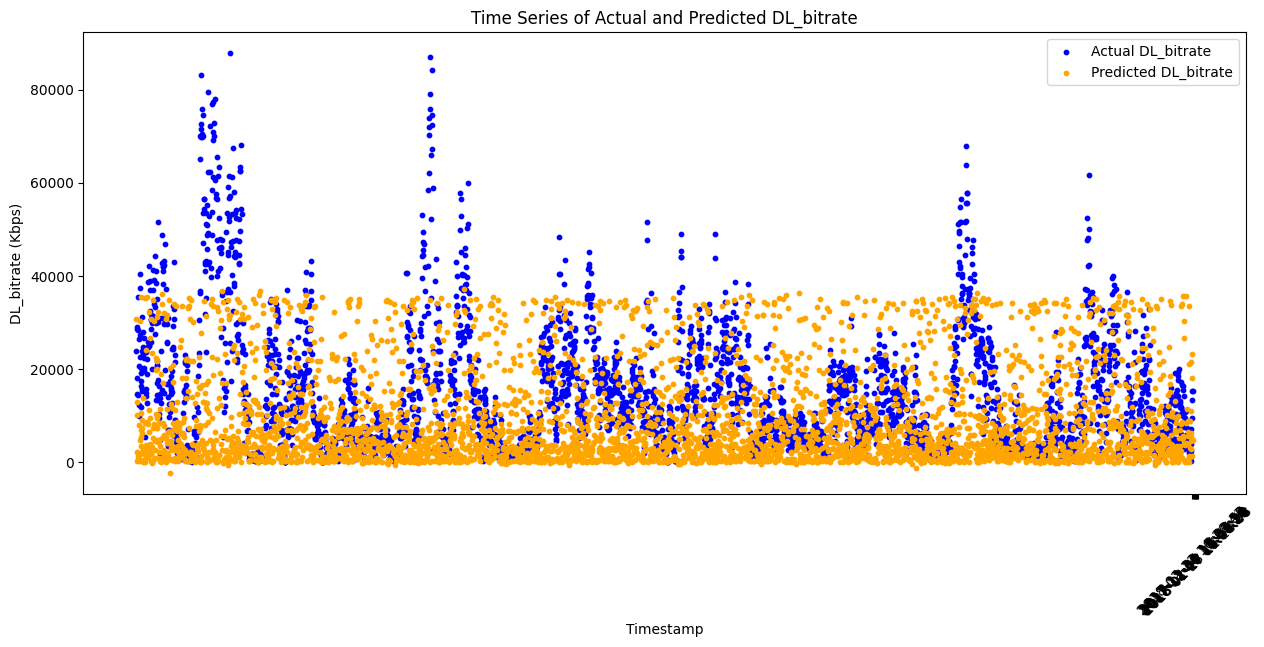

In [ ]:
# --- Σχεδίαση Χρονοσειράς για τις πραγματικές και τις προβλεπόμενες τιμές
initial_df = pd.read_csv("/content/drive/MyDrive/combined_dataset.csv")
initial_df['Timestamp'] = df['Timestamp'].astype(str)

plt.figure(figsize=(15, 6))

# Σχεδιάζουμε την πραγματική χρονοσειρά για τα δεδομένα του test set
plt.scatter(initial_df['Timestamp'].iloc[-len(y_test_pred_denorm):], initial_df['DL_bitrate'].iloc[-len(y_test_pred_denorm):], color='blue', label="Actual DL_bitrate", s=10)

# Σχεδιάζουμε την προβλεπόμενη χρονοσειρά για τα δεδομένα του test set
plt.scatter(df['Timestamp'].iloc[-len(y_test_pred_denorm):], df['Predicted_DL_bitrate'].iloc[-len(y_test_pred_denorm):], color='orange', label="Predicted DL_bitrate", s=10)

# Προσθήκη ετικετών στον άξονα x και y
plt.xlabel("Timestamp")
plt.ylabel("DL_bitrate (Kbps)")

# Προσθήκη τίτλου στο γράφημα
plt.title("Time Series of Actual and Predicted DL_bitrate")

# Μείωση των ticks στον άξονα x για καλύτερη αναγνωσιμότητα
plt.xticks(ticks=df['Timestamp'][::max(1, len(df) // 10)].iloc[-len(y_test_pred_denorm):], rotation=45)

# Προσθήκη υπομνήματος (legend)
plt.legend()

# Εμφάνιση του γραφήματος
plt.show()

 99%|===================| 25718/25964 [01:45<00:01]       

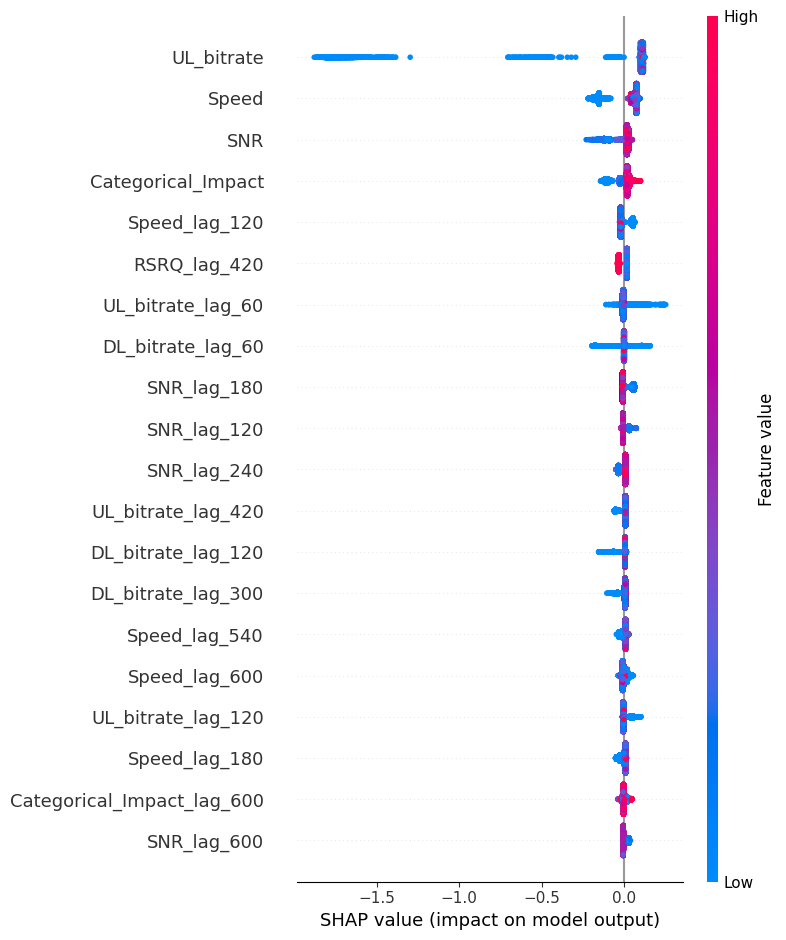

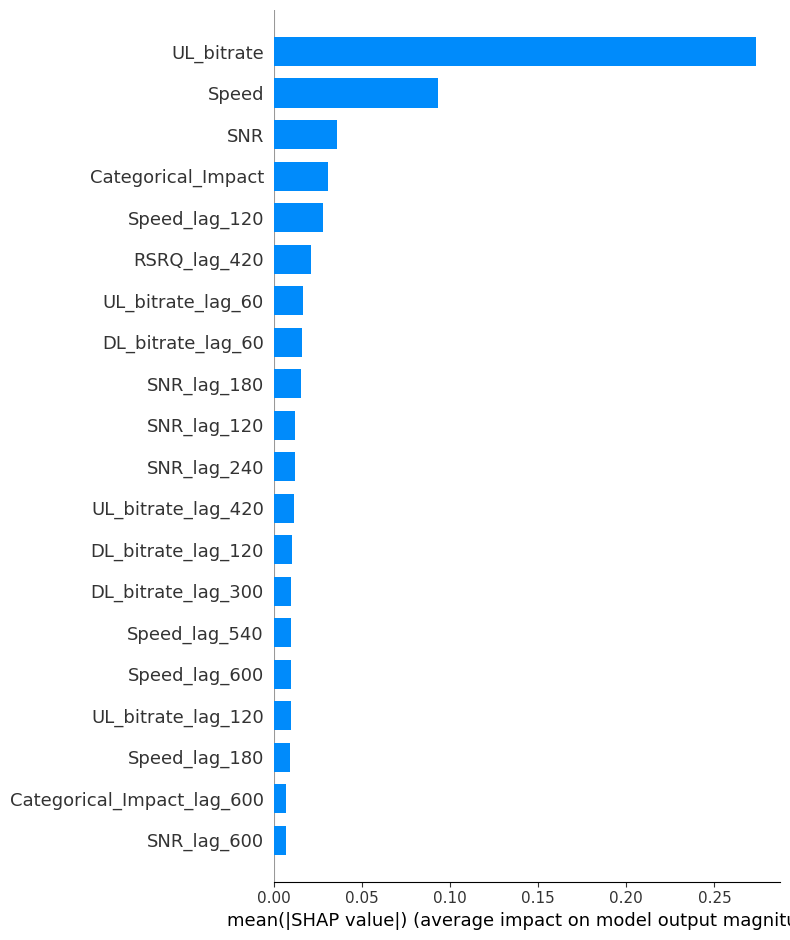

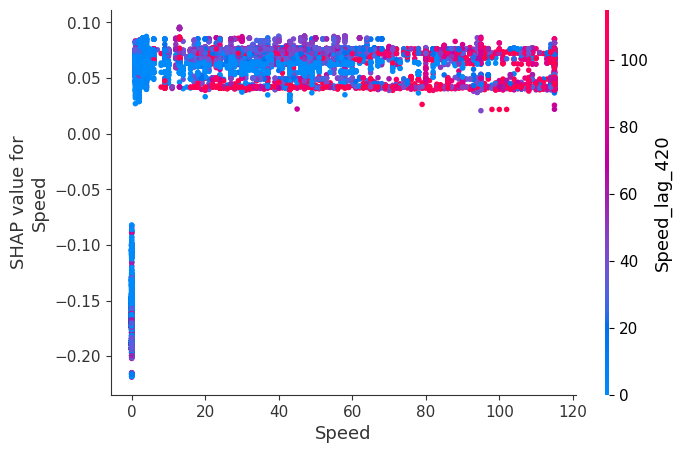

In [8]:
import shap
import xgboost
import pandas as pd

# === Δημιουργία SHAP Explainer ===
# Προσοχή: Ο explainer χρειάζεται raw (μη scaled) δεδομένα
X_test_df = pd.DataFrame(scaler_X.inverse_transform(X_test), columns=X.columns)

# SHAP Explainer για XGBoost
explainer = shap.Explainer(bst, X_test_df)

# Υπολογισμός SHAP values
shap_values = explainer(X_test_df)

# === SHAP Summary Plot (beeswarm) ===
shap.summary_plot(shap_values, X_test_df, plot_type="dot")

# === SHAP Bar Plot ===
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# === SHAP Dependence Plot (π.χ. για 'Speed') ===
shap.dependence_plot("Speed", shap_values.values, X_test_df)

# === SHAP Force Plot για ένα δείγμα ===
shap.initjs()  # Χρήσιμο για Jupyter notebook
sample_idx = 0
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx].values,
    X_test_df.iloc[sample_idx]
)
